In [1]:
import os
import matplotlib
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

In [2]:
def rbfkernel(X1, X2, gamma):
    return np.exp(-gamma*cdist(X1, X2, 'sqeuclidean'))


def polykernel(X):
    K = np.zeros(shape=(len(X), len(X)))
    for i in range(len(X)):
        for j in range(len(X)):
            k = 1 + np.dot(X[i].T,X[j]) ## K(i,j) = ( 1 + x(i).T . x(j) )^p
            k = k**2
            K[i][j] = k
    return K


def read_image(path, H, W):
    pics = os.listdir(path)
    images = np.zeros((W*H, len(pics)))
    labels = np.zeros(len(pics)).astype('uint8')
    for pic, i in zip(pics, np.arange(len(pics))):
        labels[i] = int(pic.split('.')[0][7:9])-1
        image = np.asarray(Image.open(os.path.join(path,pic)).resize((W,H),Image.ANTIALIAS)).flatten()
        images[:,i] = image

    return images, labels


def print_face(X, num, H, W):
    print("eigenface: ")
    n = int(num**0.5)
    axes = []
    fig = plt.figure()
    for i in range(num):
        axes.append(fig.add_subplot(n, n, i+1) )
        axes[-1].axis('off')
        plt.imshow(X[:,i].reshape(H,W), cmap='gray')
        
    fig.tight_layout()
    plt.show()
    

def print_reconstruction(X_original, X_reconstruction, num, H, W):
    print("Original: ")
    randint = np.random.choice(X_original.shape[1],num)
    axes = []
    fig = plt.figure()
    for i in range(num):
        axes.append(fig.add_subplot(1, num, i+1) )
        axes[-1].axis('off')
        plt.imshow(X_original[:,randint[i]].reshape(H,W),cmap='gray')
    fig.tight_layout()
    plt.show()
    
    print("Reconstruction: ")
    axes = []
    fig = plt.figure()
    for i in range(num):
        axes.append(fig.add_subplot(1, num, i+1) )
        axes[-1].axis('off')
        plt.imshow(X_reconstruction[:,randint[i]].reshape(H,W),cmap='gray')
        
    fig.tight_layout()
    plt.show()
    
    
def performance(X_test,y_test,Z_train,y_train,U,X_mean=None,k=3):
    if X_mean is None:
        X_mean=np.zeros((X_test.shape[0],1))

    # reduce dim (projection)
    Z_test=U.T@(X_test-X_mean)

    # k-nn
    predicted_y=np.zeros(Z_test.shape[1])
    for i in range(Z_test.shape[1]):
        distance=np.zeros(Z_train.shape[1])
        for j in range(Z_train.shape[1]):
            distance[j]=np.sum(np.square(Z_test[:,i]-Z_train[:,j]))
        sort_index=np.argsort(distance)
        nearest_neighbors=y_train[sort_index[:k]]
        unique, counts = np.unique(nearest_neighbors, return_counts=True)
        nearest_neighbors=[k for k,v in sorted(dict(zip(unique, counts)).items(), 
                                               key=lambda item: -item[1])]
        predicted_y[i]=nearest_neighbors[0]

    acc=np.count_nonzero((y_test-predicted_y)==0)/len(y_test)
    return acc

# refrences
https://www.youtube.com/watch?v=g-Hb26agBFg&ab_channel=Serrano.Academy

https://kknews.cc/code/a6olrln.html

https://www.uj5u.com/houduan/294222.html

# PCA

In [3]:
# SVD = U@Sigma@V.T
def pca(X, num_dim=None):
    # step 1: around center
    X_mean = np.mean(X, axis=1).reshape(-1, 1)
    X_center = X - X_mean      
    
    # step 2: X.T@X to caculate sigma&V
    eigenvalues, eigenvectors = np.linalg.eig(X_center.T @ X_center) 
    print("V shape: ", eigenvectors.shape)
    
    # step 3: sort eigenvalue big 2 small
    sort_index = np.argsort(-eigenvalues)       
    
    # step 4: delete eigenvalue<0 
    if num_dim is None:
        for eigenvalue, i in zip(eigenvalues[sort_index], 
                                 np.arange(len(eigenvalues))):
            if eigenvalue <= 0:                        
                sort_index = sort_index[:i]
                break
    else:
        sort_index = sort_index[:num_dim]

    eigenvalues = eigenvalues[sort_index]
    
    # step 5: U = (1/sigma)X@V
    eigenvectors = X_center@eigenvectors[:, sort_index]
    eigenvectors_norm = np.linalg.norm(eigenvectors,axis=0)
    eigenvectors = eigenvectors/eigenvectors_norm
    print("U shape: ", eigenvectors.shape)

    return eigenvalues, eigenvectors, X_mean

In [4]:
def pca_main():
    filepath = os.path.join('Yale_Face_Database', 'Training')
    H, W = 231, 195
    X, y = read_image(filepath, H, W)
    print('X shape: ', X.shape)
    
    accs = [] 
    for num_dim in range(3, 136):
        eigenvalues, eigenvectors, X_mean = pca(X, num_dim=num_dim)

        # Transform matrix
        U = eigenvectors.copy()

        # print 25 eigenface
#         print_face(U, 25, H, W)

        # reduce dim (projection)
        Z = U.T@(X - X_mean)

        # reconstruction
        X_reconstruction = U@Z + X_mean
#         print_reconstruction(X, X_reconstruction, 10, H, W)

        # accuracy
        filepath = os.path.join('Yale_Face_Database','Testing')
        X_test, y_test = read_image(filepath, H, W)

        for k in range(7,8):
            acc = performance(X_test, y_test, Z, y, U, X_mean, k = k)
            accs.append(acc)
            print('num_dim: {}, k: {} ,acc: {:.2f}%'.format(num_dim, k, acc * 100))
    return accs

In [25]:
accs = pca_main()

X shape:  (45045, 135)
V shape:  (135, 135)
U shape:  (45045, 3)
num_dim: 3, k: 7 ,acc: 70.00%
V shape:  (135, 135)
U shape:  (45045, 4)
num_dim: 4, k: 7 ,acc: 66.67%
V shape:  (135, 135)
U shape:  (45045, 5)
num_dim: 5, k: 7 ,acc: 80.00%
V shape:  (135, 135)
U shape:  (45045, 6)
num_dim: 6, k: 7 ,acc: 73.33%
V shape:  (135, 135)
U shape:  (45045, 7)
num_dim: 7, k: 7 ,acc: 80.00%
V shape:  (135, 135)
U shape:  (45045, 8)
num_dim: 8, k: 7 ,acc: 80.00%
V shape:  (135, 135)
U shape:  (45045, 9)
num_dim: 9, k: 7 ,acc: 80.00%
V shape:  (135, 135)
U shape:  (45045, 10)
num_dim: 10, k: 7 ,acc: 80.00%
V shape:  (135, 135)
U shape:  (45045, 11)
num_dim: 11, k: 7 ,acc: 80.00%
V shape:  (135, 135)
U shape:  (45045, 12)
num_dim: 12, k: 7 ,acc: 80.00%
V shape:  (135, 135)
U shape:  (45045, 13)
num_dim: 13, k: 7 ,acc: 83.33%
V shape:  (135, 135)
U shape:  (45045, 14)
num_dim: 14, k: 7 ,acc: 83.33%
V shape:  (135, 135)
U shape:  (45045, 15)
num_dim: 15, k: 7 ,acc: 83.33%
V shape:  (135, 135)
U shape:

num_dim: 113, k: 7 ,acc: 86.67%
V shape:  (135, 135)
U shape:  (45045, 114)
num_dim: 114, k: 7 ,acc: 86.67%
V shape:  (135, 135)
U shape:  (45045, 115)
num_dim: 115, k: 7 ,acc: 86.67%
V shape:  (135, 135)
U shape:  (45045, 116)
num_dim: 116, k: 7 ,acc: 86.67%
V shape:  (135, 135)
U shape:  (45045, 117)
num_dim: 117, k: 7 ,acc: 86.67%
V shape:  (135, 135)
U shape:  (45045, 118)
num_dim: 118, k: 7 ,acc: 86.67%
V shape:  (135, 135)
U shape:  (45045, 119)
num_dim: 119, k: 7 ,acc: 86.67%
V shape:  (135, 135)
U shape:  (45045, 120)
num_dim: 120, k: 7 ,acc: 86.67%
V shape:  (135, 135)
U shape:  (45045, 121)
num_dim: 121, k: 7 ,acc: 86.67%
V shape:  (135, 135)
U shape:  (45045, 122)
num_dim: 122, k: 7 ,acc: 86.67%
V shape:  (135, 135)
U shape:  (45045, 123)
num_dim: 123, k: 7 ,acc: 86.67%
V shape:  (135, 135)
U shape:  (45045, 124)
num_dim: 124, k: 7 ,acc: 86.67%
V shape:  (135, 135)
U shape:  (45045, 125)
num_dim: 125, k: 7 ,acc: 86.67%
V shape:  (135, 135)
U shape:  (45045, 126)
num_dim: 126

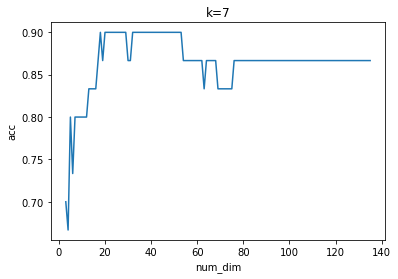

In [26]:
num_dim = [i for i in range(3,136)]
plt.plot(num_dim, accs)
plt.title('k=7')
plt.xlabel('num_dim')
plt.ylabel('acc')
plt.show()

# kernel PCA

In [5]:
def kpca(X, num_dim, kernel):
    # step0: kernel
    if kernel == 'RBF':
        gamma = 0.01
        X = rbfkernel(X, X, gamma)
        
    elif kernel == 'polynomial':
        X = polykernel(X)

    # step 1: around center
    X_mean = np.mean(X, axis=1).reshape(-1, 1)
    X_center = X - X_mean      
    
    # step 2: X.T@X to caculate sigma&V
    eigenvalues, eigenvectors = np.linalg.eig(X_center.T @ X_center) 
    print("V shape: ", eigenvectors.shape)
    
    # step 3: sort eigenvalue big 2 small
    sort_index = np.argsort(-eigenvalues)       
    
    # step 4: delete eigenvalue<0 
    if num_dim is None:
        for eigenvalue, i in zip(eigenvalues[sort_index], 
                                 np.arange(len(eigenvalues))):
            if eigenvalue <= 0:                        
                sort_index = sort_index[:i]
                break
    else:
        sort_index = sort_index[:num_dim]

    eigenvalues = eigenvalues[sort_index]
    
    # step 5: U = (1/sigma)X@V
    eigenvectors = X_center@eigenvectors[:, sort_index]
    eigenvectors_norm = np.linalg.norm(eigenvectors,axis=0)
    eigenvectors = eigenvectors/eigenvectors_norm
    print("U shape: ", eigenvectors.shape)

    return eigenvalues, eigenvectors, X_mean

In [6]:
def kpca_main():
    filepath = os.path.join('Yale_Face_Database', 'Training')
    H, W = 231, 195
    X, y = read_image(filepath, H, W)
    print('X shape: ', X.shape)
    
    accs = [] 
    for num_dim in range(3, 136):
        eigenvalues, eigenvectors, X_mean = kpca(X, num_dim=num_dim, kernel='RBF')

        # Transform matrix
        U = eigenvectors.copy()

        # print 25 eigenface
#         print_face(U, 25, H, W)

        # reduce dim (projection)
        Z = U.T@(X - X_mean)

        # reconstruction
        X_reconstruction = U@Z + X_mean
#         print_reconstruction(X, X_reconstruction, 10, H, W)

        # accuracy
        filepath = os.path.join('Yale_Face_Database','Testing')
        X_test, y_test = read_image(filepath, H, W)

        for k in range(7,8):
            acc = performance(X_test, y_test, Z, y, U, X_mean, k = k)
            accs.append(acc)
            print('num_dim: {}, k: {} ,acc: {:.2f}%'.format(num_dim, k, acc * 100))
    return accs

In [ ]:
accs = kpca_main()